In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
livetime = 48 * u.h
n_obs = 500
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
model = [] 
mod = SkyModel(spectral_model=model_simu)
model.append(mod)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [6]:
l = [0.01,0.1,0.2,0.3,0.5,1,2,3,5]
simu = []
for i in range(9):
    sim = ExpCutoffPowerLawSpectralModel(
        index=2.22,
        amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=l[i] * u.Unit("TeV-1"),
        alpha = 1,
    )
    mod = SkyModel(spectral_model=sim)
    simu.append(sim)
    model.append(mod)
    print(model[i+1])
    print(simu[i])

SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  Fa

In [7]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [9]:
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
data = []
for i in range(len(model)):
    dataset.model = model[i]
    dataset.fake(random_state=42)
    print(dataset)
    data.append(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit 

In [11]:
data_onoff = []
for i in range(len(model)):
    dataset_onoff = SpectrumDatasetOnOff(
        aeff=dataset.aeff,
        edisp=dataset.edisp,
        models=model[i],
        livetime=livetime,
        acceptance=1,
        acceptance_off=5,
    )
    dataset_onoff.fake(background_model=dataset.background)
    print(dataset_onoff)
    data_onoff.append(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37236 
    Total predicted counts          : 37265.74
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36734 
    Total predicted counts          : 37066.34
    Total off counts                : 101786.00

    Total background counts         : 20357.20

  

In [12]:
%%time
datas = []
for i in range(len(model)):
    datasets = []
    for idx in range(n_obs):
        data_onoff[i].fake(random_state=idx, background_model=dataset.background)
        data_onoff[i].name = f"obs_{idx}"
        datasets.append(data_onoff[i].copy())
    datas.append(datasets)

CPU times: user 30.9 s, sys: 223 ms, total: 31.2 s
Wall time: 48.7 s


In [13]:
len(datas)
print(*datas[0], sep = "\n")

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37107 
    Total predicted counts          : 37257.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36990 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 2


SpectrumDatasetOnOff

    Name                            : obs_14 

    Total counts                    : 37526 
    Total predicted counts          : 37285.14
    Total off counts                : 101796.00

    Total background counts         : 20359.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_15 

    Total counts                    : 36828 
    Total predicted counts          : 37212.14
    Total off counts                : 101431.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_25 

    Total counts                    : 37199 
    Total predicted counts          : 37230.94
    Total off counts                : 101525.00

    Total background counts         : 20305.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 37397 
    Total predicted counts          : 37253.94
    Total off counts                : 101640.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_41 

    Total counts                    : 37193 
    Total predicted counts          : 37225.94
    Total off counts                : 101500.00

    Total background counts         : 20300.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.09

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_42 

    Total counts                    : 37095 
    Total predicted counts          : 37142.94
    Total off counts                : 101085.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_56 

    Total counts                    : 37182 
    Total predicted counts          : 37217.54
    Total off counts                : 101458.00

    Total background counts         : 20291.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_57 

    Total counts                    : 37311 
    Total predicted counts          : 37230.54
    Total off counts                : 101523.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_67 

    Total counts                    : 37143 
    Total predicted counts          : 37271.54
    Total off counts                : 101728.00

    Total background counts         : 20345.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_68 

    Total counts                    : 37330 
    Total predicted counts          : 37142.14
    Total off counts                : 101081.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_85 

    Total counts                    : 37208 
    Total predicted counts          : 37162.74
    Total off counts                : 101184.00

    Total background counts         : 20236.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 37073 
    Total predicted counts          : 37211.54
    Total off counts                : 101428.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_96 

    Total counts                    : 37329 
    Total predicted counts          : 37269.74
    Total off counts                : 101719.00

    Total background counts         : 20343.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_97 

    Total counts                    : 37134 
    Total predicted counts          : 37205.34
    Total off counts                : 101397.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_111 

    Total counts                    : 37125 
    Total predicted counts          : 37214.54
    Total off counts                : 101443.00

    Total background counts         : 20288.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.40

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_112 

    Total counts                    : 37189 
    Total predicted counts          : 37140.14
    Total off counts                : 101071.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_122 

    Total counts                    : 37151 
    Total predicted counts          : 37309.74
    Total off counts                : 101919.00

    Total background counts         : 20383.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.77

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_123 

    Total counts                    : 37297 
    Total predicted counts          : 37261.14
    Total off counts                : 101676.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_133 

    Total counts                    : 37011 
    Total predicted counts          : 37253.74
    Total off counts                : 101639.00

    Total background counts         : 20327.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_134 

    Total counts                    : 37184 
    Total predicted counts          : 37242.94
    Total off counts                : 101585.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_151 

    Total counts                    : 37431 
    Total predicted counts          : 37269.54
    Total off counts                : 101718.00

    Total background counts         : 20343.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.33

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_152 

    Total counts                    : 37081 
    Total predicted counts          : 37270.74
    Total off counts                : 101724.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_170 

    Total counts                    : 37052 
    Total predicted counts          : 37102.34
    Total off counts                : 100882.00

    Total background counts         : 20176.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_171 

    Total counts                    : 37388 
    Total predicted counts          : 37280.74
    Total off counts                : 101774.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 37210 
    Total predicted counts          : 37280.74
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.66

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_182 

    Total counts                    : 37026 
    Total predicted counts          : 37288.14
    Total off counts                : 101811.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 37148 
    Total predicted counts          : 37261.14
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 37072 
    Total predicted counts          : 37257.54
    Total off counts                : 101658.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_204 

    Total counts                    : 37309 
    Total predicted counts          : 37218.94
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_205 

    Total counts                    : 37181 
    Total predicted counts          : 37361.74
    Total off counts                : 102179.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_218 

    Total counts                    : 37342 
    Total predicted counts          : 37166.54
    Total off counts                : 101203.00

    Total background counts         : 20240.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.51

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_219 

    Total counts                    : 37102 
    Total predicted counts          : 37247.34
    Total off counts                : 101607.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 37486 
    Total predicted counts          : 37176.74
    Total off counts                : 101254.00

    Total background counts         : 20250.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_230 

    Total counts                    : 37512 
    Total predicted counts          : 37317.34
    Total off counts                : 101957.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_243 

    Total counts                    : 37043 
    Total predicted counts          : 37312.54
    Total off counts                : 101933.00

    Total background counts         : 20386.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_244 

    Total counts                    : 37092 
    Total predicted counts          : 37196.74
    Total off counts                : 101354.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_256 

    Total counts                    : 37190 
    Total predicted counts          : 37380.34
    Total off counts                : 102272.00

    Total background counts         : 20454.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_257 

    Total counts                    : 37343 
    Total predicted counts          : 37194.94
    Total off counts                : 101345.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_271 

    Total counts                    : 36995 
    Total predicted counts          : 37298.94
    Total off counts                : 101865.00

    Total background counts         : 20373.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.62

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_272 

    Total counts                    : 37504 
    Total predicted counts          : 37198.74
    Total off counts                : 101364.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 37481 
    Total predicted counts          : 37235.54
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.15

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_284 

    Total counts                    : 36859 
    Total predicted counts          : 37195.94
    Total off counts                : 101350.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_294 

    Total counts                    : 37145 
    Total predicted counts          : 37229.34
    Total off counts                : 101517.00

    Total background counts         : 20303.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.33

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_295 

    Total counts                    : 37305 
    Total predicted counts          : 37232.34
    Total off counts                : 101532.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_311 

    Total counts                    : 37271 
    Total predicted counts          : 37302.74
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_312 

    Total counts                    : 37107 
    Total predicted counts          : 37213.14
    Total off counts                : 101436.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_330 

    Total counts                    : 37356 
    Total predicted counts          : 37293.54
    Total off counts                : 101838.00

    Total background counts         : 20367.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_331 

    Total counts                    : 37693 
    Total predicted counts          : 37234.14
    Total off counts                : 101541.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_341 

    Total counts                    : 37325 
    Total predicted counts          : 37247.94
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 37365 
    Total predicted counts          : 37148.34
    Total off counts                : 101112.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_361 

    Total counts                    : 37420 
    Total predicted counts          : 37122.54
    Total off counts                : 100983.00

    Total background counts         : 20196.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_362 

    Total counts                    : 37420 
    Total predicted counts          : 37320.14
    Total off counts                : 101971.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_372 

    Total counts                    : 37115 
    Total predicted counts          : 37224.34
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_373 

    Total counts                    : 37220 
    Total predicted counts          : 37229.54
    Total off counts                : 101518.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_394 

    Total counts                    : 36964 
    Total predicted counts          : 37293.14
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.18

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 37115 
    Total predicted counts          : 37229.34
    Total off counts                : 101517.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_413 

    Total counts                    : 37097 
    Total predicted counts          : 37263.94
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_414 

    Total counts                    : 37278 
    Total predicted counts          : 37191.14
    Total off counts                : 101326.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_431 

    Total counts                    : 37190 
    Total predicted counts          : 37326.74
    Total off counts                : 102004.00

    Total background counts         : 20400.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_432 

    Total counts                    : 37483 
    Total predicted counts          : 37372.14
    Total off counts                : 102231.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_450 

    Total counts                    : 37429 
    Total predicted counts          : 37318.74
    Total off counts                : 101964.00

    Total background counts         : 20392.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_451 

    Total counts                    : 37170 
    Total predicted counts          : 37284.74
    Total off counts                : 101794.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_470 

    Total counts                    : 37151 
    Total predicted counts          : 37129.34
    Total off counts                : 101017.00

    Total background counts         : 20203.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 37119 
    Total predicted counts          : 37233.94
    Total off counts                : 101540.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_481 

    Total counts                    : 37282 
    Total predicted counts          : 37191.94
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.05

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_482 

    Total counts                    : 36907 
    Total predicted counts          : 37170.74
    Total off counts                : 101224.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_498 

    Total counts                    : 37190 
    Total predicted counts          : 37223.94
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_499 

    Total counts                    : 37606 
    Total predicted counts          : 37262.14
    Total off counts                : 101681.00

    Total background counts         

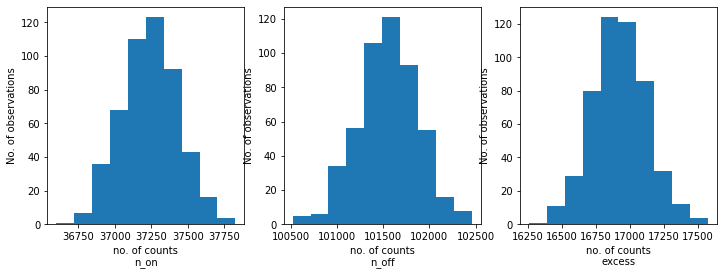

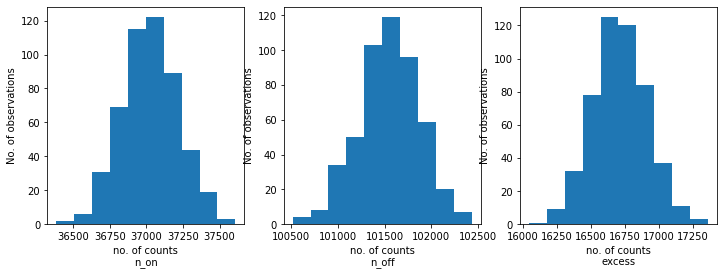

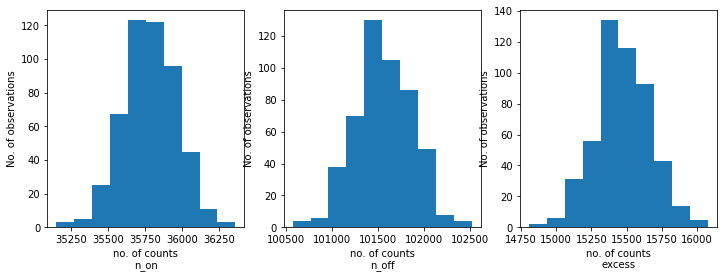

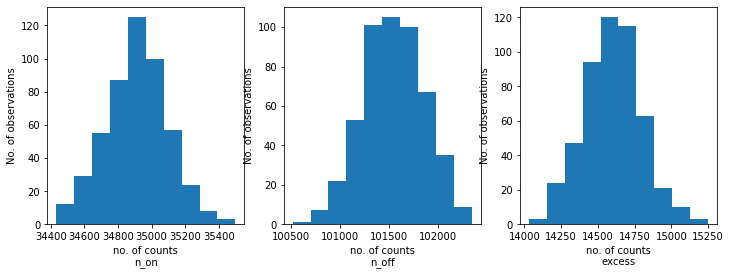

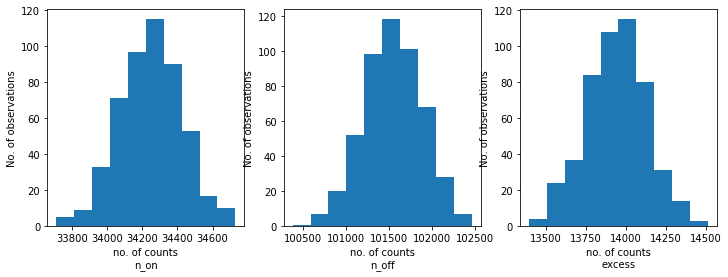

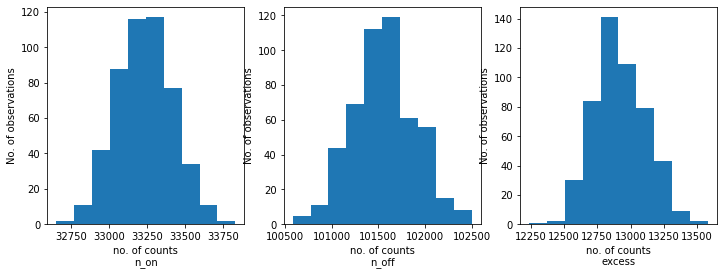

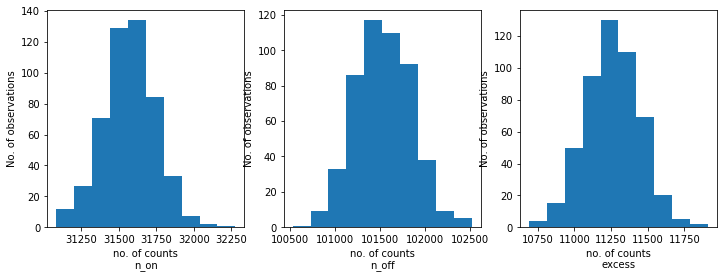

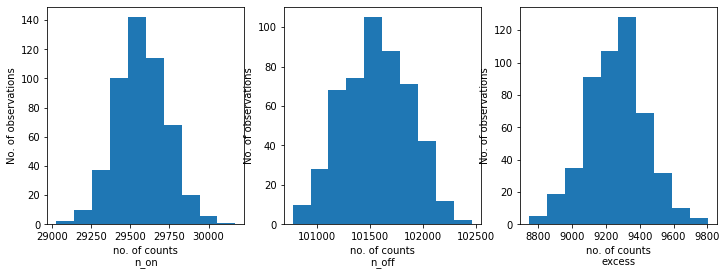

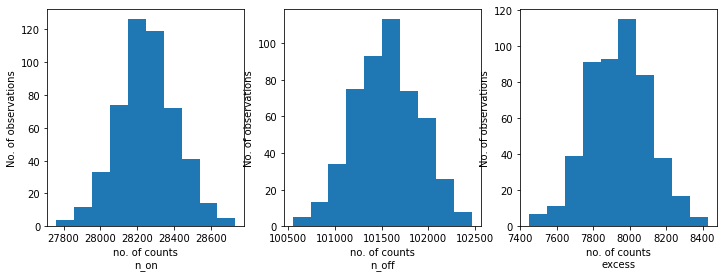

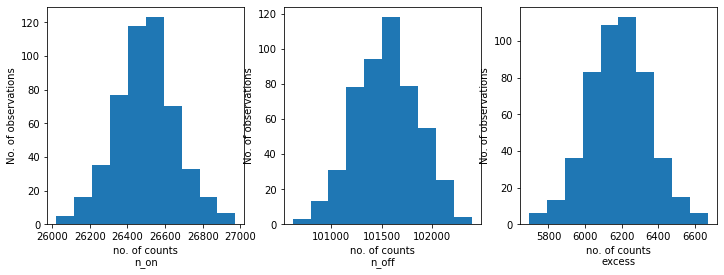

In [14]:
for i in range(10):
    n_on = [dataset.counts.data.sum() for dataset in datas[i]]
    n_off = [dataset.counts_off.data.sum() for dataset in datas[i]]
    excess = [dataset.excess.data.sum() for dataset in datas[i]]
    
    fix, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(n_on)
    axes[0].set_xlabel("no. of counts\nn_on")
    axes[0].set_ylabel("No. of observations")
    axes[1].hist(n_off)
    axes[1].set_xlabel("no. of counts\nn_off")
    axes[1].set_ylabel("No. of observations")
    axes[2].hist(excess)
    axes[2].set_xlabel("no. of counts\nexcess");
    axes[2].set_ylabel("No. of observations")

In [15]:
%%time
res = []
results = []
for dataset in datas[0]:
    dataset.models = model[0].copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
        }
    )
    print(result.parameters.to_table())
res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

In [16]:
for i in range(9):
    results = []
    for dataset in datas[i+1]:
        dataset.models = model[i+1].copy()
        fit = Fit([dataset])
        result = fit.optimize()
        results.append(
            {
                "index": result.parameters["index"].value,
                "amplitude": result.parameters["amplitude"].value,
                "lambda_": result.parameters["lambda_"].value,
                "reference":result.parameters["reference"].value,
                "alpha":result.parameters["alpha"].value,
            }
        )
        print(result.parameters.to_table())
    res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.335e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.248e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.252e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.381e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.711e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.201e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.301e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.053e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.831e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.439e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.195e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.696e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.312e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.471e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.256e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.063e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.222e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.976e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.186e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.840e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.467e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.710e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.329e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.461e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.415e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.637e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.463e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.684e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.169e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.370e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.990e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.011e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.019e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.357e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.207e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.294e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.025e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.095e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.841e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.320e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.038e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.319e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.196e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.759e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.545e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.484e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.210e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.371e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.017e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.089e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.081e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.082e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.003e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.187e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.040e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.018e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.049e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.070e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.210e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.010e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.004e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.483e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.029e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.349e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.263e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.128e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.339e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.583e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.874e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.029e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.043e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.033e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.339e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.202e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.805e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.279e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.351e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.342e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.170e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.236e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.389e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.108e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.569e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.946e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.499e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.231e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.789e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.079e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.249e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.767e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.084e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.486e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.075e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.454e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.140e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.735e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.326e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.022e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.779e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.076e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.019e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.927e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.652e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.361e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.345e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.913e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.865e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.040e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.186e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.037e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.875e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.029e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.098e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.148e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.370e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.351e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.373e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.026e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.381e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.210e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.764e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.340e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.313e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.012e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.332e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.124e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.085e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.350e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.235e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.932e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.173e+00   nan                nan nan  False
amplitude 1.419e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.654e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.916e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.814e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.043e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.094e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.999e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.068e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.978e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.079e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.336e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.934e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.869e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.923e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.914e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.125e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.326e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.926e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.010e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.241e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.874e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.360e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.236e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.096e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.949e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.067e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.840e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.054e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.362e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.134e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.096e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.186e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.338e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.372e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.148e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.957e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.083e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.337e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.131e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.370e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.452e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.286e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.018e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.534e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.202e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.244e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.332e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.418e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.273e+00   nan                nan nan  False
amplitude 1.165e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.382e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.503e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.841e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.808e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.896e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.596e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.880e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.362e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.385e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.218e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.673e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.328e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.997e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.175e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.785e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.956e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.297e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.968e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.397e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.145e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.979e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.161e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.352e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.282e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.406e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.389e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.368e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.712e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.148e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.982e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.374e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.148e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.935e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.672e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.907e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.596e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.711e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.882e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.972e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.890e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.402e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.038e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.933e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.229e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.380e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.422e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.249e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.993e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.345e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.239e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.328e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.154e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.107e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.046e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.222e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.662e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.219e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.175e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.326e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.345e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.873e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.354e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.934e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.380e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.762e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.713e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.347e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.255e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.366e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.115e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.382e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.636e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.659e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.279e+00   nan                nan nan  False
amplitude 1.094e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.035e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.336e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.180e+00   nan                nan nan  False
amplitude 1.407e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.689e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.026e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.085e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.927e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.473e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.864e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.242e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.232e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.777e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.399e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.332e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.047e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.202e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.389e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.367e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.367e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.734e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.344e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.287e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.210e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.882e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.209e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.584e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.640e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.815e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.407e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.351e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.352e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.346e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.369e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.123e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.885e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.350e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.035e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.393e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.591e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.455e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.884e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.348e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.608e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.392e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.748e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.770e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.208e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.509e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.795e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.973e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.193e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.648e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.411e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.186e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.977e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.772e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.159e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.553e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.450e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.148e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.811e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.812e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.461e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.369e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.056e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.575e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.534e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.182e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.554e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.355e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.005e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.176e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.289e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.447e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.086e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.177e+00   nan                nan nan  False
amplitude 1.419e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.702e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.354e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.181e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.147e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.410e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.044e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.502e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.145e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.063e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.463e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.028e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.701e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.418e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.628e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.024e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.452e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.765e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.082e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.011e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.160e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.495e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.018e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.203e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.783e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.503e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.022e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.892e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.131e+00   nan                nan nan  False
amplitude 1.643e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.255e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.156e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.058e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.021e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.419e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.037e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.651e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.439e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.111e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.150e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.320e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.273e+00   nan                nan nan  False
amplitude 1.136e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.462e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.172e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.496e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.124e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 1.166e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.510e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.122e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.080e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.167e+00   nan                nan nan  False
amplitude 1.518e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.245e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.964e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.712e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.404e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.463e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.247e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.990e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.349e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.019e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.350e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.042e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.538e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.297e+00   nan                nan nan  False
amplitude 1.018e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.758e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.363e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.212e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.430e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.981e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.182e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.897e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.157e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.899e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.395e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.224e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.075e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.917e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.169e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.913e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.047e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.380e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.459e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.378e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.332e+00   nan                nan nan  False
amplitude 9.546e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.557e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.192e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.234e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.894e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.108e+00   nan                nan nan  False
amplitude 1.633e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.291e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.486e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.299e+00   nan                nan nan  False
amplitude 1.045e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.789e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.371e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.031e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.359e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.102e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.976e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.875e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.312e+00   nan                nan nan  False
amplitude 1.005e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.768e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.382e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.229e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.894e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.876e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.277e+00   nan                nan nan  False
amplitude 1.171e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.353e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.292e+00   nan                nan nan  False
amplitude 1.002e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.571e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 1.139e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.124e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.784e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.349e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.103e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.139e+00   nan                nan nan  False
amplitude 1.582e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.234e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.382e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.049e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.489e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.121e+00   nan                nan nan  False
amplitude 1.684e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.472e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.882e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.143e+00   nan                nan nan  False
amplitude 1.622e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.956e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.337e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.970e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.036e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.876e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.345e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.089e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.935e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.508e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.243e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.114e+00   nan                nan nan  False
amplitude 1.718e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.417e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.436e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.199e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.019e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.871e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.317e+00   nan                nan nan  False
amplitude 1.011e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.755e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.128e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.788e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.381e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.986e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.867e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.350e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.077e+00   nan                nan nan  False
amplitude 1.986e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.767e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.288e+00   nan                nan nan  False
amplitude 1.041e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.768e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.284e+00   nan                nan nan  False
amplitude 1.041e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.177e+00   nan                nan nan  False
amplitude 1.495e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.391e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.297e+00   nan                nan nan  False
amplitude 1.020e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.536e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.160e+00   nan                nan nan  False
amplitude 1.501e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.344e+00   nan                nan nan  False
amplitude 9.360e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.419e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.084e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.567e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.036e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.477e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.272e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.082e+00   nan                nan nan  False
amplitude 1.966e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.742e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.376e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.329e+00   nan                nan nan  False
amplitude 9.576e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.603e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.132e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.999e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.138e+00   nan                nan nan  False
amplitude 1.610e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.573e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.408e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.414e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.012e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.073e+00   nan                nan nan  False
amplitude 1.880e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.355e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.101e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.316e+00   nan                nan nan  False
amplitude 9.737e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.493e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.171e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.806e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.176e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.090e+00   nan                nan nan  False
amplitude 1.747e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.152e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.618e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.056e+00   nan                nan nan  False
amplitude 2.126e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.735e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.589e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.347e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.636e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.471e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.172e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.914e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.428e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.006e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.208e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.947e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.112e+00   nan                nan nan  False
amplitude 1.760e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.407e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.155e+00   nan                nan nan  False
amplitude 1.606e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.148e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.692e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.063e+00   nan                nan nan  False
amplitude 1.965e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.709e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.232e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.321e+00   nan                nan nan  False
amplitude 9.664e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.449e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.395e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.263e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.897e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.251e+00   nan                nan nan  False
amplitude 1.142e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.785e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.294e+00   nan                nan nan  False
amplitude 1.086e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.108e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.712e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.325e+00   nan                nan nan  False
amplitude 1.025e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.797e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.394e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.427e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.992e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.386e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.090e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.464e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.121e+00   nan                nan nan  False
amplitude 1.721e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.421e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.187e+00   nan                nan nan  False
amplitude 1.480e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.229e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.021e+00   nan                nan nan  False
amplitude 2.234e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 9.929e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.249e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.126e+00   nan                nan nan  False
amplitude 1.646e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.283e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.112e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.346e+00   nan                nan nan  False
amplitude 9.141e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.578e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.424e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.250e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.120e+00   nan                nan nan  False
amplitude 1.724e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.200e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.765e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.055e+00   nan                nan nan  False
amplitude 2.038e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.825e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.330e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.267e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.154e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.941e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.332e+00   nan                nan nan  False
amplitude 9.298e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.307e+00   nan                nan nan  False
amplitude 9.900e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.592e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.166e+00   nan                nan nan  False
amplitude 1.528e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.284e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.274e+00   nan                nan nan  False
amplitude 1.109e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.318e+00   nan                nan nan  False
amplitude 1.003e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.605e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.123e+00   nan                nan nan  False
amplitude 1.661e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.554e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.902e+00   nan                nan nan  False
amplitude 3.509e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.313e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.148e+00   nan                nan nan  False
amplitude 1.557e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.136e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.993e+00   nan                nan nan  False
amplitude 2.629e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.037e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.167e+00   nan                nan nan  False
amplitude 1.579e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.623e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.107e+00   nan                nan nan  False
amplitude 1.846e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.672e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.066e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.450e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.275e+00   nan                nan nan  False
amplitude 1.018e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.134e+00   nan                nan nan  False
amplitude 1.645e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.308e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.516e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.711e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.389e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.982e+00   nan                nan nan  False
amplitude 2.796e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.687e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.108e+00   nan                nan nan  False
amplitude 1.812e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.597e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.045e+00   nan                nan nan  False
amplitude 2.302e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.998e+00   nan                nan nan  False
amplitude 3.034e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.711e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.062e+00   nan                nan nan  False
amplitude 1.888e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.590e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.780e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.556e+00   nan                nan nan  False
amplitude 4.543e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.681e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.147e+00   nan                nan nan  False
amplitude 1.733e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.544e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.004e+00   nan                nan nan  False
amplitude 2.642e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.965e+00   nan                nan nan  False
amplitude 2.667e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.111e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.371e+00   nan                nan nan  False
amplitude 8.297e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.333e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.283e+00   nan                nan nan  False
amplitude 1.021e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.290e+00   nan                nan nan  False
amplitude 1.142e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.820e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.093e+00   nan                nan nan  False
amplitude 1.831e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.431e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.000e+00   nan                nan nan  False
amplitude 2.745e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.017e+00   nan                nan nan  False
amplitude 2.417e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.070e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.181e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.752e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.989e+00   nan                nan nan  False
amplitude 2.626e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.255e+00   nan                nan nan  False
amplitude 1.080e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.384e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.233e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.885e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.379e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.434e+00   nan                nan nan  False
amplitude 6.202e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.283e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.215e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.686e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.074e+00   nan                nan nan  False
amplitude 1.963e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.297e+00   nan                nan nan  False
amplitude 9.330e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.696e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.311e+00   nan                nan nan  False
amplitude 9.682e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.360e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.949e+00   nan                nan nan  False
amplitude 2.932e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.106e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.771e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.906e+00   nan                nan nan  False
amplitude 3.458e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.171e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.422e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.032e+00   nan                nan nan  False
amplitude 2.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.239e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.106e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.184e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.169e+00   nan                nan nan  False
amplitude 1.414e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.517e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.203e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.915e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.110e+00   nan                nan nan  False
amplitude 1.907e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.086e+00   nan                nan nan  False
amplitude 1.879e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.591e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.433e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.705e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.277e+00   nan                nan nan  False
amplitude 1.058e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.318e+00   nan                nan nan  False
amplitude 1.015e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.851e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.394e+00   nan                nan nan  False
amplitude 7.486e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.851e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.054e+00   nan                nan nan  False
amplitude 2.111e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.151e+00   nan                nan nan  False
amplitude 1.563e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.554e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.526e+00   nan                nan nan  False
amplitude 4.809e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.862e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.830e+00   nan                nan nan  False
amplitude 4.312e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.998e+00   nan                nan nan  False
amplitude 2.857e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.128e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.009e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.939e+00   nan                nan nan  False
amplitude 2.988e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.405e+00   nan                nan nan  False
amplitude 7.222e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.106e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.036e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.378e+00   nan                nan nan  False
amplitude 7.300e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.299e+00   nan                nan nan  False
amplitude 1.077e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.777e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.293e+00   nan                nan nan  False
amplitude 1.118e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.941e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.997e+00   nan                nan nan  False
amplitude 2.550e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.018e+00   nan                nan nan  False
amplitude 2.338e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.065e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.327e+00   nan                nan nan  False
amplitude 8.848e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.262e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.274e+00   nan                nan nan  False
amplitude 1.060e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.961e+00   nan                nan nan  False
amplitude 2.928e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.752e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.627e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.949e+00   nan                nan nan  False
amplitude 3.031e-12   nan cm-2 s-1 TeV-1 nan nan

In [17]:
import scipy.stats as stats
import math

In [18]:
index = []
amplitude = []
lambda_ = []
reference = []
alpha = []
covar = []
a = np.array([_["index"] for _ in res[0]])
b = np.array([_["amplitude"] for _ in res[0]])
c = np.array([_["reference"] for _ in res[0]])
index.append(a)
amplitude.append(b)
reference.append(c)
for i in range(9):
    a = np.array([_["index"] for _ in res[i+1]])
    b = np.array([_["amplitude"] for _ in res[i+1]])
    c = np.array([_["reference"] for _ in res[i+1]])
    d = np.array([_["lambda_"] for _ in res[i+1]])
    e = np.array([_["alpha"] for _ in res[i+1]])
    index.append(a)
    amplitude.append(b)
    reference.append(c)
    lambda_.append(d)
    alpha.append(e)
    
mu = [0,0,0,0,0,0,0,0,0,0]
sigma = [0,0,0,0,0,0,0,0,0,0]
np_hist = [0,0,0,0,0,0,0,0,0,0]
x = np.array([index[0], amplitude[0], reference[0]])
covar.append(np.cov(x))
for i in range(9):
    x = np.array([index[i+1], amplitude[i+1], reference[i+1], lambda_[i], alpha[i]])
    covar.append(np.cov(x))

index: 2.2202469716127387 += 0.006802230378957911
index: 2.2203121951380345 += 0.009250108062548376
index: 2.219842704584508 += 0.01348043647633226
index: 2.2198331713885824 += 0.01651208698309843
index: 2.219389302547137 += 0.01941848110424698
index: 2.2182108071277185 += 0.022816873068319168
index: 2.2169101964134987 += 0.03217920184219841
index: 2.2165602553902852 += 0.05316500430791073
index: 2.2113559092045914 += 0.08209196705592067
index: 2.2026344505289908 += 0.13757732162277314


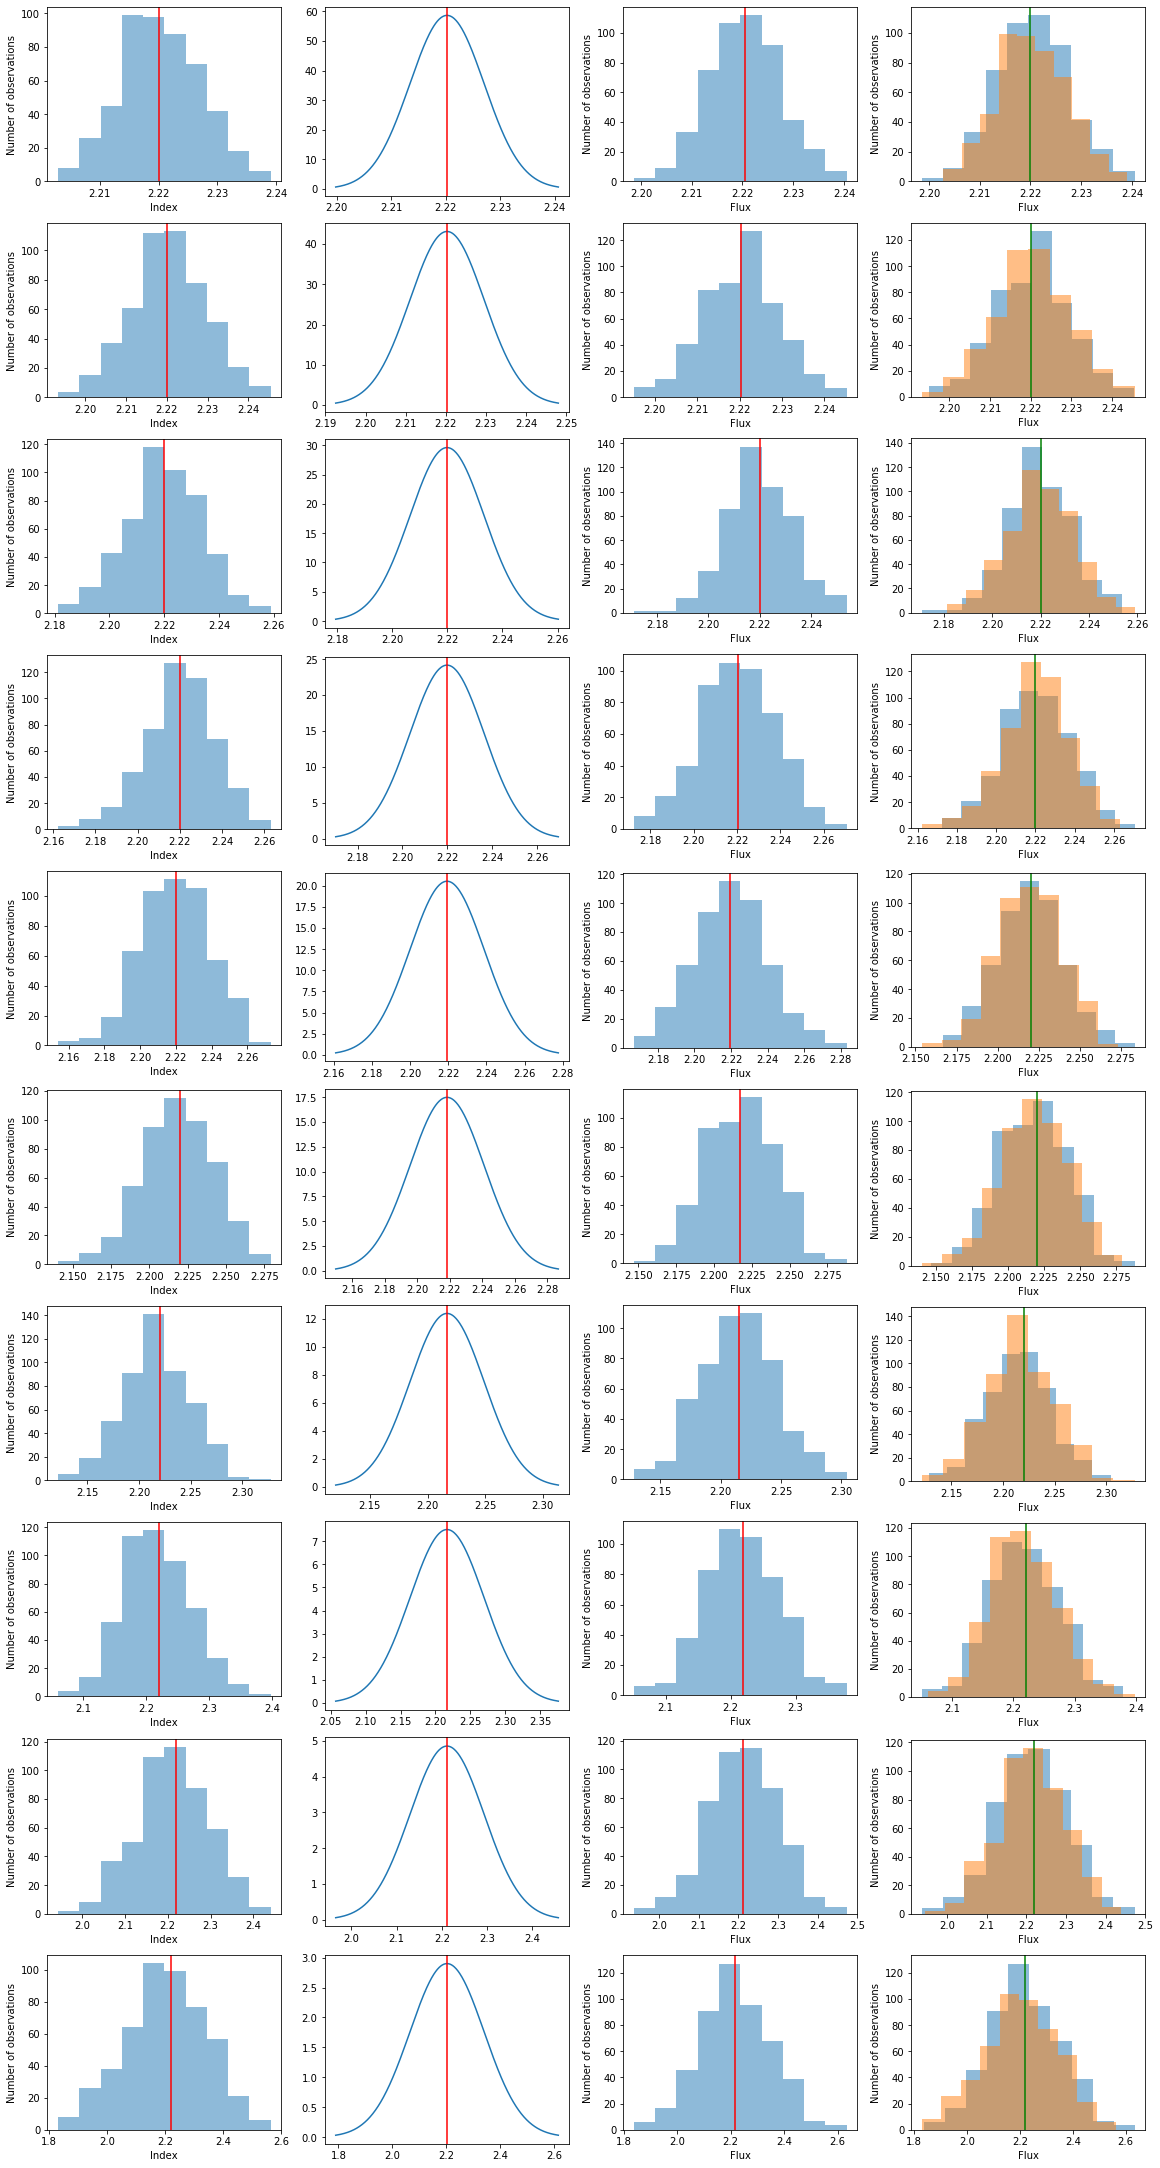

In [19]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n].mean()} += {index[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n+1].mean()} += {index[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = index[n].mean()
    sigma[n] = index[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

amplitude: 1.2886890578979226e-12 += 1.3354938209221958e-14
amplitude: 1.288890497962218e-12 += 1.80611510633627e-14
amplitude: 1.2896437787842434e-12 += 3.018332627055102e-14
amplitude: 1.2907475576083914e-12 += 4.056317942424548e-14
amplitude: 1.2927615963436678e-12 += 5.00579005623978e-14
amplitude: 1.2951506764273662e-12 += 6.382414137282786e-14
amplitude: 1.3023691738455963e-12 += 1.0067000624138924e-13
amplitude: 1.3155721619013931e-12 += 1.872768336526147e-13
amplitude: 1.3586205289026581e-12 += 3.325012470314825e-13
amplitude: 1.4988008657305354e-12 += 6.876838878169021e-13


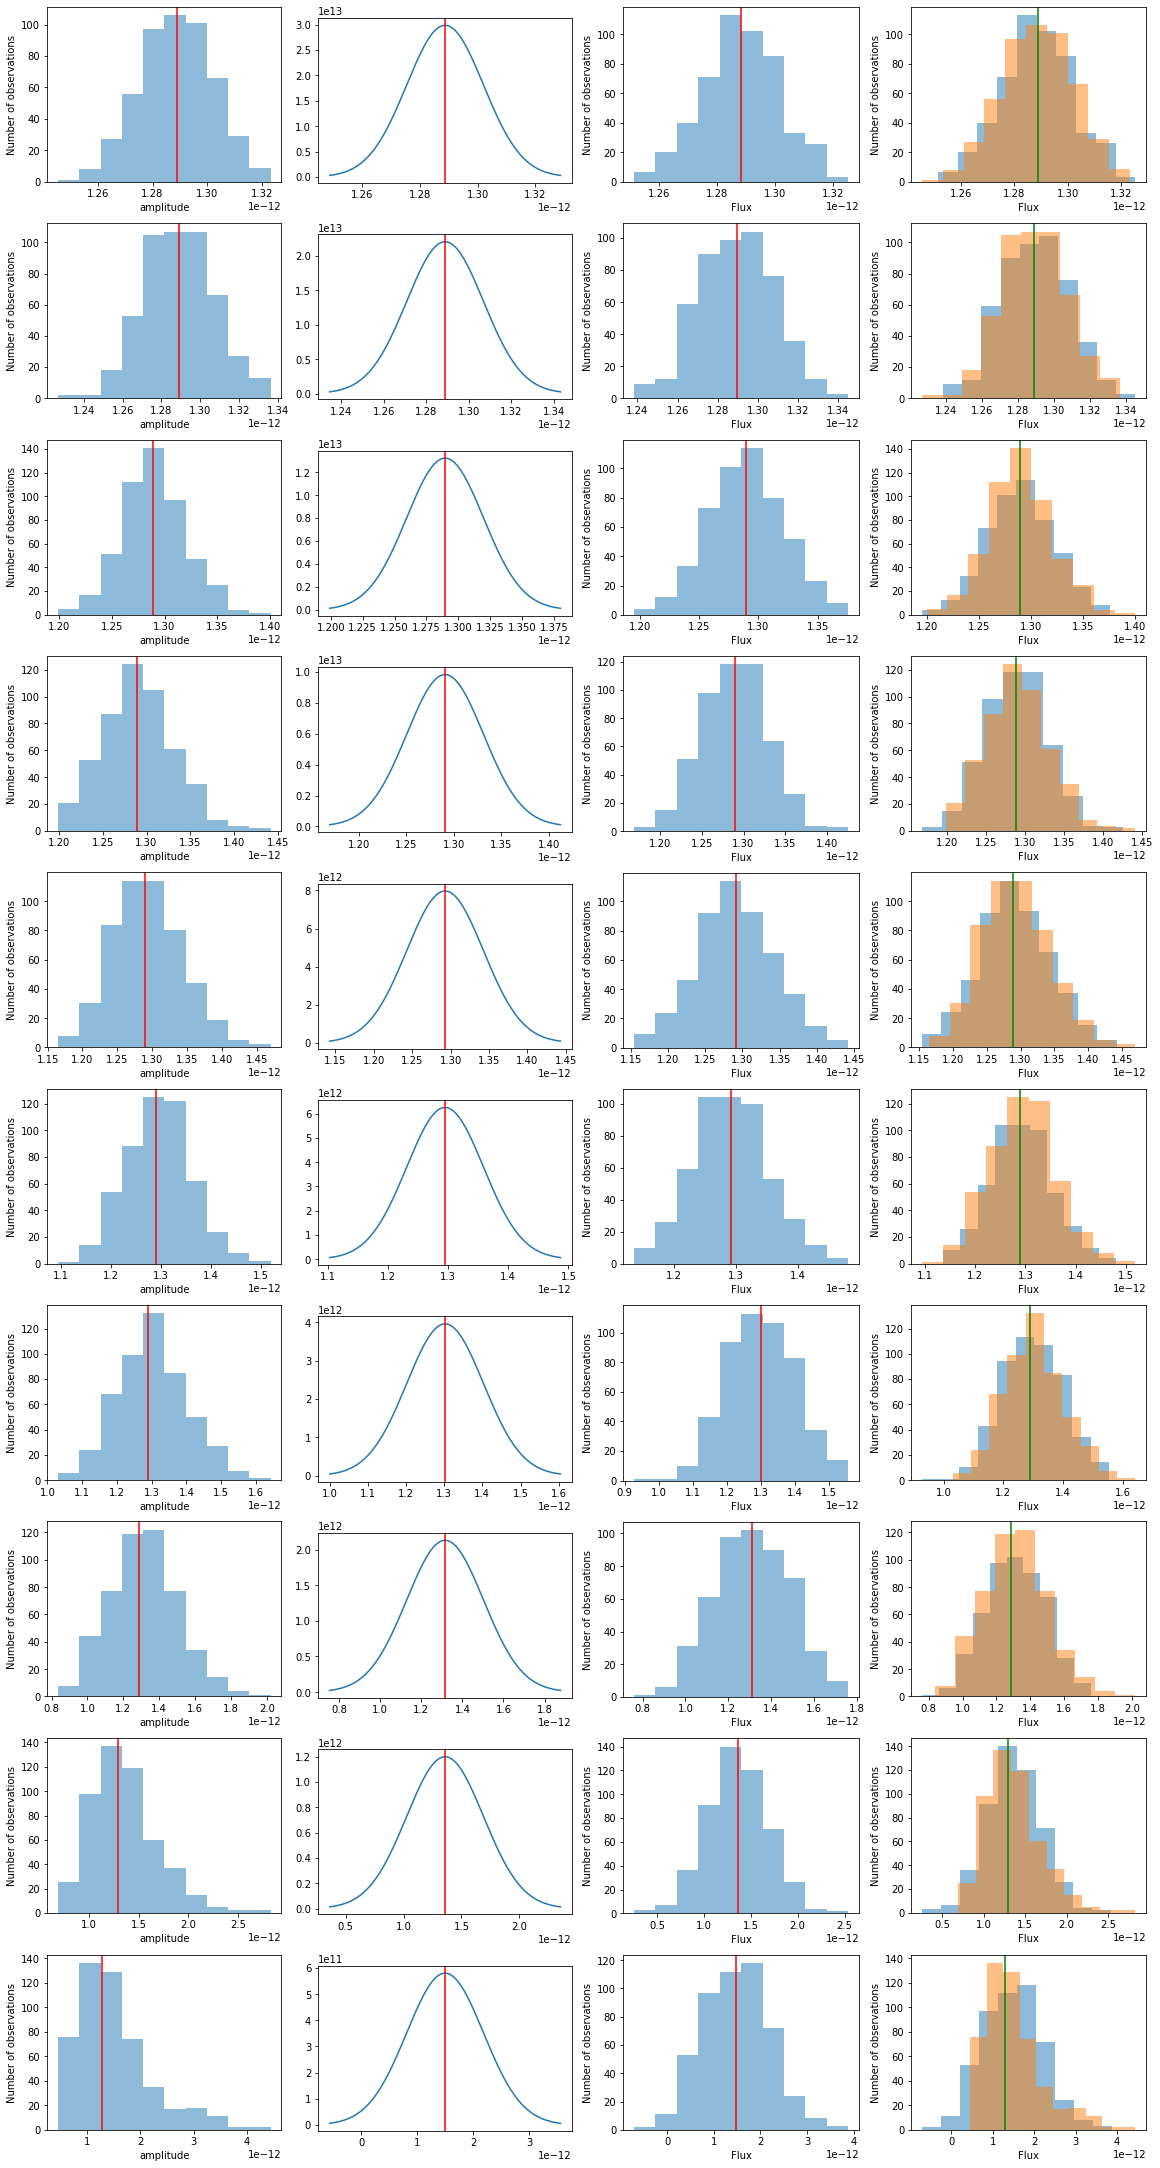

In [20]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n].mean()} += {amplitude[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n+1].mean()} += {amplitude[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = amplitude[n].mean()
    sigma[n] = amplitude[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

lambda_: 0.010097459990373286 += 0.002675467226745824
lambda_: 0.10046312364632183 += 0.009071331494553594
lambda_: 0.20107564110469348 += 0.016197457348760276
lambda_: 0.3020786114718322 += 0.023978175790440776
lambda_: 0.5039228887653991 += 0.03724544264390231
lambda_: 1.0079008712540156 += 0.08030988126769599
lambda_: 2.0189768231193583 += 0.20844722886976097
lambda_: 3.039753821286851 += 0.41865022758912035
lambda_: 5.133534621076356 += 0.9555793167713277


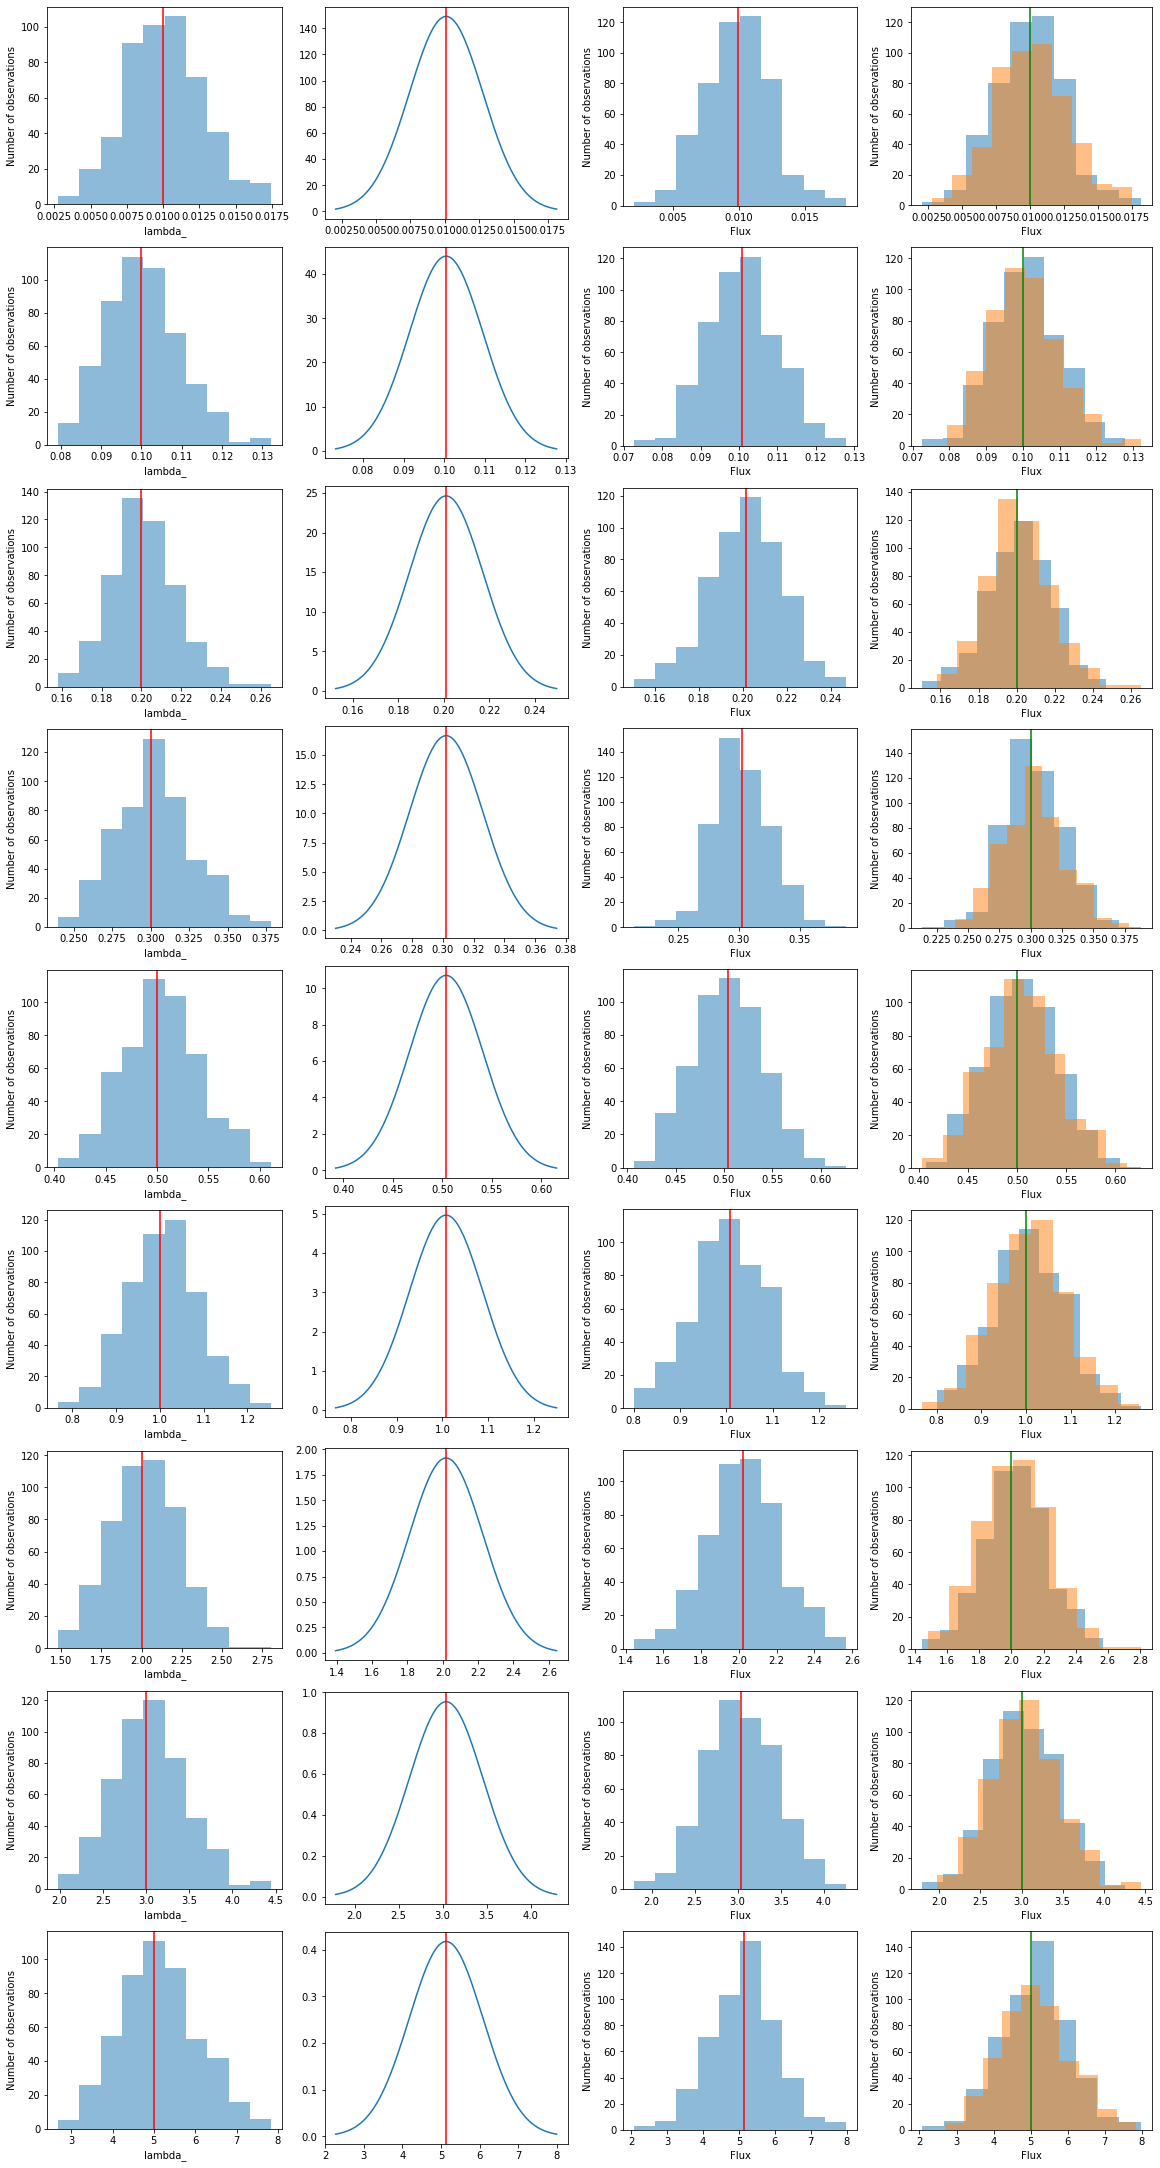

In [21]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[0])
for n in range(9):
    ax = fig.add_subplot(gs1[n])
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="red")
    plt.xlabel("lambda_")
    plt.ylabel("Number of observations")
    print(f"lambda_: {lambda_[n].mean()} += {lambda_[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[1])
for n in range(9):
    ax = fig.add_subplot(gs2[n])
    mu[n] = lambda_[n].mean()
    sigma[n] = lambda_[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[2])
for n in range(9):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[3])    
for n in range(9):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

In [22]:
sim = [] 
s = PowerLawSpectralModel(
    index=index[0].mean(),
    amplitude=amplitude[0].mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(s)
sim.append(s)

for i in range(9):
    s = ExpCutoffPowerLawSpectralModel(
        index=index[i+1].mean(),
        amplitude=amplitude[i+1].mean() * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=lambda_[i].mean() * u.Unit("TeV-1"),
        alpha = 1,
    )
    print(s)
    sim.append(s)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.010e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+

<function matplotlib.pyplot.show(*args, **kw)>

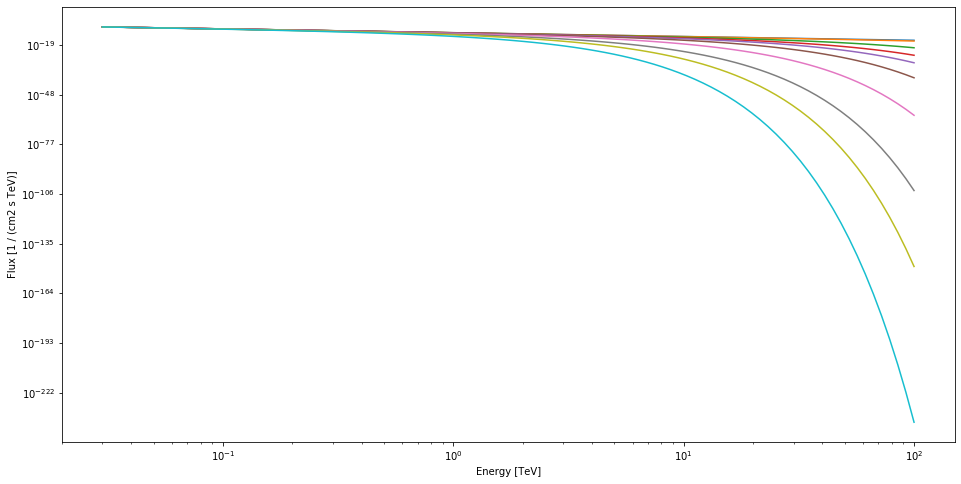

In [23]:
plt.figure(figsize=[16,8])
energy_range = [0.03, 100] * u.TeV
sim[0].plot(energy_range)
for i in range(9):
    sim[i+1].plot(energy_range)
plt.show

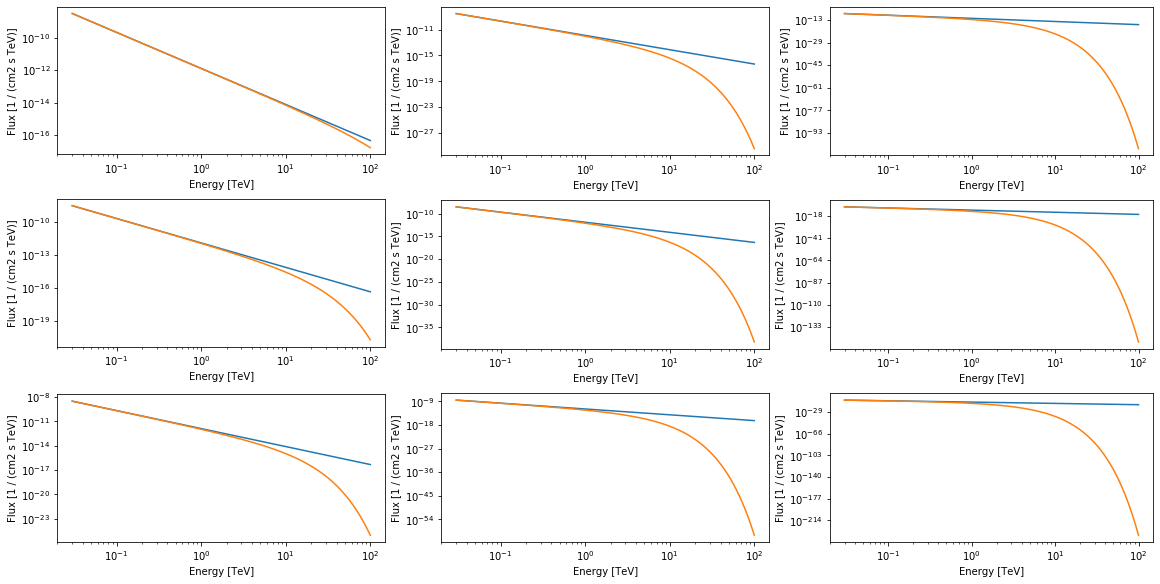

In [24]:
fig = plt.figure(figsize=[16,8],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range)
    sim[n+1].plot(energy_range)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range)
    sim[n+4].plot(energy_range)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range)
    sim[n+7].plot(energy_range)
    
plt.show()

In [25]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [26]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

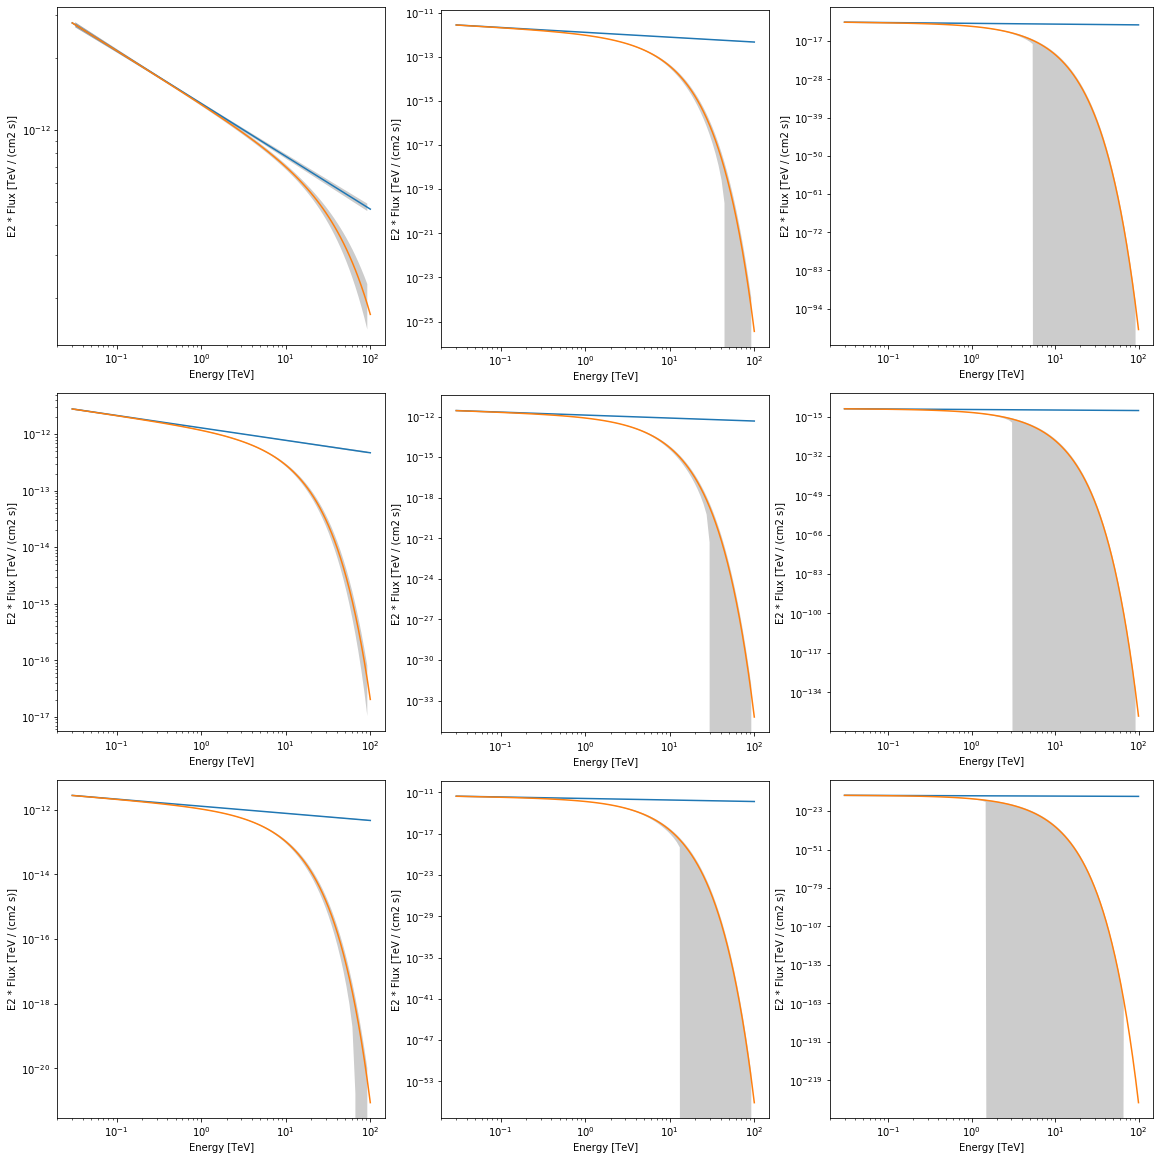

In [27]:
fig = plt.figure(figsize=[16,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+1].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+1], covar=covar[n+1],energy_range=energy_range, energy_power=2)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+4].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+4], covar=covar[n+4],energy_range=energy_range, energy_power=2)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+7].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+7], covar=covar[n+7],energy_range=energy_range, energy_power=2)
    
plt.show()